# Object Detection Demo
Welcome to the object detection inference walkthrough!
This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. 
Make sure to follow the [installation instructions](https://github.com/wonheeML/mtl-ssl-detection/object_detection/g3doc/preparation.md) before you start.

# Frozen inference graph
You can download the frozen graph we provide or you can [create the frozen graph](../g3doc/exporting_models.md) yourself.

Download and unzip pretrained frozen graph in object_detection/checkpoints/frozen

[model21](https://drive.google.com/file/d/1soKE_qn_jqA7YmhClhgl4B7shEQMdsWV/view?usp=sharing)

[model22](https://drive.google.com/file/d/1BvSfhBL1hppEA3TlqoZMdTv0_41UTaJB/view?usp=sharing)



# Imports

In [1]:
# This is needed to display the images.
%matplotlib inline

import os
print(os.getcwd())
cur_dir = os.getcwd()

if len(cur_dir) > 17 and cur_dir[-17:] == 'mtl-ssl-detection':
  root_dir = cur_dir
elif len(cur_dir) > 16 and cur_dir[-16:] == 'object_detection':
  root_dir = cur_dir[:-17]
elif len(cur_dir) > 9 and cur_dir[-9:] == 'notebooks':
  root_dir = cur_dir[:-26]
else:
  root_dir = cur_dir

os.chdir(root_dir)
print(os.getcwd())

/data/source/cvpr_public/mtl-ssl-detection
/data/source/cvpr_public/mtl-ssl-detection


In [2]:
# import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from PIL import Image
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

from IPython.core.display import HTML
HTML("<style>.container { width:98% !important; }</style>")

<style>.container { width:98% !important; }</style>

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "Faster R-CNN with ResNet101" model here.

In [3]:
MODEL_NAME = 'model21'
DATASET = 'mscoco' # 'mscoco' or 'pascal'

 
ROOT_PATH = './object_detection/'
PATH_TO_CKPT = ROOT_PATH + 'checkpoints/frozen/' + MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_LABELS = ROOT_PATH + 'data/' + DATASET + '_label_map.pbtxt'
NUM_CLASSES = 20
if DATASET == 'mscoco':
  NUM_CLASSES = 90

## Load a (frozen) Tensorflow model into memory.

In [4]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

NotFoundError: ./object_detection/checkpoints/frozen/model21/frozen_inference_graph.pb; No such file or directory

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [7]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Helper code

In [8]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [9]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = './object_detection/test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)
FONT_SIZE = 50

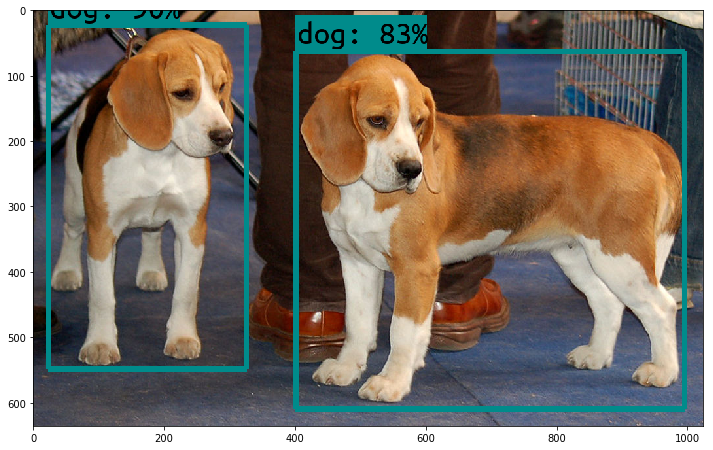

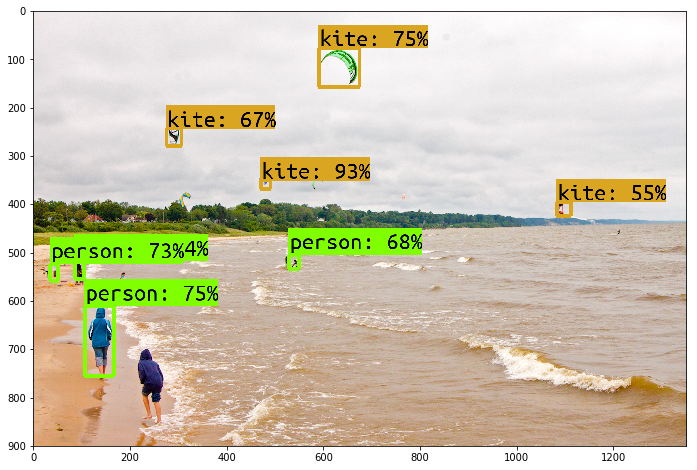

In [10]:
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    for image_path in TEST_IMAGE_PATHS:
      image = Image.open(image_path)
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
      
      # Each box represents a part of the image where a particular object was detected.
      boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
      
      # Each score represent how level of confidence for each of the objects.
      # Score is shown on the result image, together with the class label.
      scores = detection_graph.get_tensor_by_name('detection_scores:0')
      classes = detection_graph.get_tensor_by_name('detection_classes:0')
      num_detections = detection_graph.get_tensor_by_name('num_detections:0')
      
      # Actual detection.
      (boxes, scores, classes, num_detections) = sess.run(
          [boxes, scores, classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      
      # Visualization of the results of a detection.
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=8,
          font_size=FONT_SIZE)
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)